In [1]:
import pandas as pd
sbarabarnaIdDataset =  pd.read_csv('BdSL_Combined_Dataset.csv') 

In [4]:
# Examine the dataset structure
print("Dataset shape:", sbarabarnaIdDataset.shape)
print("\nColumn names:")
print(sbarabarnaIdDataset.columns.tolist())
print("\nFirst few rows:")
print(sbarabarnaIdDataset.head())
print("\nDataset info:")
print(sbarabarnaIdDataset.info())
print("\nMissing values:")
print(sbarabarnaIdDataset.isnull().sum())
print("\nTarget variable distribution:")
if 'label' in sbarabarnaIdDataset.columns:
    print(sbarabarnaIdDataset['label'].value_counts())
elif 'target' in sbarabarnaIdDataset.columns:
    print(sbarabarnaIdDataset['target'].value_counts())
else:
    print("Please identify the target column name")

Dataset shape: (1949, 11)

Column names:
['p1', 'p2', 'p3', 'p4', 'p5', 'r1', 'r2', 'r3', 'r4', 'r5', 'label']

First few rows:
      p1     p2     p3     p4     p5     r1     r2     r3     r4     r5 label
0 -75.51  31.61  42.67  47.63  48.68 -24.54 -39.51 -71.11 -90.23 -96.62     আ
1 -76.55  31.19  42.15  46.97  49.23 -25.16 -37.45 -69.21 -87.12 -94.74     আ
2 -75.40  31.93  42.54  47.84  49.17 -30.79 -37.02 -67.21 -86.71 -94.30     আ
3 -76.58  31.89  41.76  46.61  48.07 -29.20 -38.75 -68.96 -86.83 -93.34     আ
4 -76.36  31.25  41.66  46.74  48.26 -25.94 -38.56 -69.46 -88.49 -95.28     আ

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p1      1949 non-null   float64
 1   p2      1949 non-null   float64
 2   p3      1949 non-null   float64
 3   p4      1949 non-null   float64
 4   p5      1949 non-null   float64
 5   r1      1949 non-n

In [5]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Data Cleaning

=== DATA CLEANING ===
Original dataset shape: (1949, 11)
Number of duplicate rows: 0
Number of outliers detected: 285


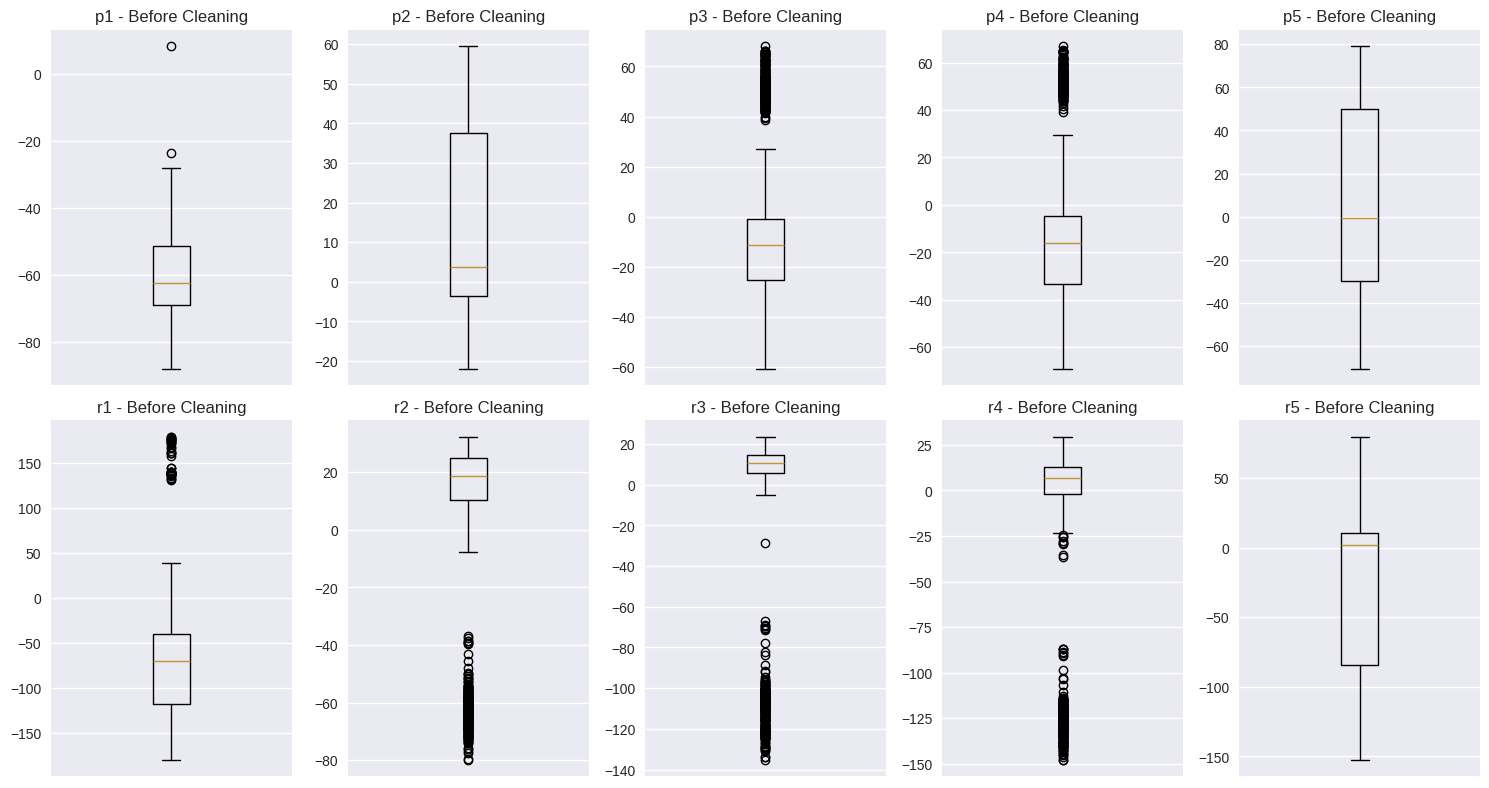

Shape after removing extreme outliers: (1905, 11)

Cleaned dataset statistics:
                p1           p2           p3           p4           p5  \
count  1905.000000  1905.000000  1905.000000  1905.000000  1905.000000   
mean    -60.187601    11.633759    -9.166268   -14.239102     7.279780   
std      13.247465    22.445343    27.909292    30.711771    45.006473   
min     -88.180000   -22.010000   -60.650000   -69.130000   -70.710000   
25%     -68.530000    -3.770000   -25.530000   -33.930000   -30.270000   
50%     -62.280000     3.420000   -11.580000   -16.280000    -1.350000   
75%     -51.200000    37.930000    -2.470000    -5.330000    50.200000   
max     -23.630000    59.590000    68.240000    67.040000    79.280000   

                r1           r2           r3           r4           r5  
count  1905.000000  1905.000000  1905.000000  1905.000000  1905.000000  
mean    -77.427192     9.598945    -3.063328    -7.913685   -25.187680  
std      43.546453    27.684622    

In [6]:
# Data Cleaning
print("=== DATA CLEANING ===")
print(f"Original dataset shape: {sbarabarnaIdDataset.shape}")

# Create a copy for cleaning
df_cleaned = sbarabarnaIdDataset.copy()

# Check for duplicates
duplicates = df_cleaned.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicates if any
if duplicates.sum() > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"Shape after removing duplicates: {df_cleaned.shape}")

# Check for outliers using IQR method
def detect_outliers_iqr(df, columns):
    outliers_indices = set()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outliers_indices.update(outliers)
    return list(outliers_indices)

# Detect outliers in feature columns
feature_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'r1', 'r2', 'r3', 'r4', 'r5']
outlier_indices = detect_outliers_iqr(df_cleaned, feature_columns)
print(f"Number of outliers detected: {len(outlier_indices)}")

# Visualize outliers before removal
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_columns, 1):
    plt.subplot(2, 5, i)
    plt.boxplot(df_cleaned[col])
    plt.title(f'{col} - Before Cleaning')
    plt.xticks([])

plt.tight_layout()
plt.show()

# Option: Remove outliers (conservative approach - remove only extreme outliers)
# Using 3 standard deviations as threshold
def remove_extreme_outliers(df, columns, threshold=3):
    df_no_outliers = df.copy()
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df_no_outliers = df_no_outliers[
            (df_no_outliers[col] >= mean - threshold * std) & 
            (df_no_outliers[col] <= mean + threshold * std)
        ]
    return df_no_outliers

df_cleaned = remove_extreme_outliers(df_cleaned, feature_columns)
print(f"Shape after removing extreme outliers: {df_cleaned.shape}")

print("\nCleaned dataset statistics:")
print(df_cleaned.describe())

# 2. Feature Engineering

In [7]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===")

# Create enhanced feature set
df_features = df_cleaned.copy()

# 1. Create derived features
# Distance features (Euclidean distances between points)
df_features['dist_p1_p2'] = np.sqrt((df_features['p1'] - df_features['p2'])**2)
df_features['dist_p2_p3'] = np.sqrt((df_features['p2'] - df_features['p3'])**2)
df_features['dist_p3_p4'] = np.sqrt((df_features['p3'] - df_features['p4'])**2)
df_features['dist_p4_p5'] = np.sqrt((df_features['p4'] - df_features['p5'])**2)

df_features['dist_r1_r2'] = np.sqrt((df_features['r1'] - df_features['r2'])**2)
df_features['dist_r2_r3'] = np.sqrt((df_features['r2'] - df_features['r3'])**2)
df_features['dist_r3_r4'] = np.sqrt((df_features['r3'] - df_features['r4'])**2)
df_features['dist_r4_r5'] = np.sqrt((df_features['r4'] - df_features['r5'])**2)

# 2. Ratio features
df_features['p_ratio_1_3'] = df_features['p1'] / (df_features['p3'] + 1e-8)  # Add small value to avoid division by zero
df_features['p_ratio_2_4'] = df_features['p2'] / (df_features['p4'] + 1e-8)
df_features['r_ratio_1_3'] = df_features['r1'] / (df_features['r3'] + 1e-8)
df_features['r_ratio_2_4'] = df_features['r2'] / (df_features['r4'] + 1e-8)

# 3. Statistical features
df_features['p_mean'] = df_features[['p1', 'p2', 'p3', 'p4', 'p5']].mean(axis=1)
df_features['p_std'] = df_features[['p1', 'p2', 'p3', 'p4', 'p5']].std(axis=1)
df_features['p_range'] = df_features[['p1', 'p2', 'p3', 'p4', 'p5']].max(axis=1) - df_features[['p1', 'p2', 'p3', 'p4', 'p5']].min(axis=1)

df_features['r_mean'] = df_features[['r1', 'r2', 'r3', 'r4', 'r5']].mean(axis=1)
df_features['r_std'] = df_features[['r1', 'r2', 'r3', 'r4', 'r5']].std(axis=1)
df_features['r_range'] = df_features[['r1', 'r2', 'r3', 'r4', 'r5']].max(axis=1) - df_features[['r1', 'r2', 'r3', 'r4', 'r5']].min(axis=1)

# 4. Cross-group features
df_features['pr_correlation'] = np.array([np.corrcoef(row[:5], row[5:10])[0,1] for row in df_features[feature_columns].values])
df_features['pr_mean_diff'] = df_features['p_mean'] - df_features['r_mean']
df_features['pr_std_diff'] = df_features['p_std'] - df_features['r_std']

# Handle any NaN values that might have been created
df_features = df_features.fillna(0)

print(f"Original features: {len(feature_columns)}")
print(f"Total features after engineering: {len(df_features.columns) - 1}")  # -1 for label column

# Show new feature names
new_features = [col for col in df_features.columns if col not in feature_columns and col != 'label']
print(f"New features created: {new_features}")

print(f"Enhanced dataset shape: {df_features.shape}")

=== FEATURE ENGINEERING ===
Original features: 10
Total features after engineering: 31
New features created: ['dist_p1_p2', 'dist_p2_p3', 'dist_p3_p4', 'dist_p4_p5', 'dist_r1_r2', 'dist_r2_r3', 'dist_r3_r4', 'dist_r4_r5', 'p_ratio_1_3', 'p_ratio_2_4', 'r_ratio_1_3', 'r_ratio_2_4', 'p_mean', 'p_std', 'p_range', 'r_mean', 'r_std', 'r_range', 'pr_correlation', 'pr_mean_diff', 'pr_std_diff']
Enhanced dataset shape: (1905, 32)


# 3. Machine Learning

In [8]:
# Machine Learning Pipeline
print("=== MACHINE LEARNING ===")

# Prepare features and target
X = df_features.drop('label', axis=1)
y = df_features['label']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Target classes: {label_encoder.classes_}")
print(f"Class distribution: {np.bincount(y_encoded)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using univariate statistical tests
selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Selected features ({len(selected_features)}): {list(selected_features)}")

print("\nFeature selection completed!")
print(f"Reduced feature matrix shape: {X_train_selected.shape}")

=== MACHINE LEARNING ===
Feature matrix shape: (1905, 31)
Target classes: ['আ' 'ই' 'উ' 'এ' 'ঐ' 'ও' 'ঔ']
Class distribution: [233 275 281 276 297 272 271]
Training set: (1524, 31)
Test set: (381, 31)
Selected features (20): ['p2', 'p3', 'p4', 'p5', 'r2', 'r3', 'r4', 'r5', 'dist_p1_p2', 'dist_p2_p3', 'dist_p4_p5', 'dist_r2_r3', 'dist_r4_r5', 'p_mean', 'p_std', 'p_range', 'r_mean', 'r_range', 'pr_mean_diff', 'pr_std_diff']

Feature selection completed!
Reduced feature matrix shape: (1524, 20)


In [9]:
# Model Training and Comparison
print("=== MODEL TRAINING ===")

# Initialize models
models = {
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy')
    
    # Train on full training set
    model.fit(X_train_selected, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    model_results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'y_test_pred': y_test_pred
    }
    
    print(f"Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Train accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")

# Find best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['test_accuracy'])
best_model = model_results[best_model_name]

print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"Test accuracy: {best_model['test_accuracy']:.4f}")

# Detailed evaluation of best model
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, best_model['y_test_pred'], 
                          target_names=label_encoder.classes_))

=== MODEL TRAINING ===

Training SVM (RBF)...
Cross-validation: 0.9993 (+/- 0.0026)
Train accuracy: 0.9993
Test accuracy: 1.0000

Training SVM (Linear)...
Cross-validation: 0.9980 (+/- 0.0032)
Train accuracy: 1.0000
Test accuracy: 0.9974

Training Random Forest...
Cross-validation: 0.9987 (+/- 0.0032)
Train accuracy: 1.0000
Test accuracy: 1.0000

Training Logistic Regression...
Cross-validation: 0.9980 (+/- 0.0053)
Train accuracy: 0.9993
Test accuracy: 0.9948

=== BEST MODEL: SVM (RBF) ===
Test accuracy: 1.0000

Detailed Classification Report for SVM (RBF):
              precision    recall  f1-score   support

           আ       1.00      1.00      1.00        47
           ই       1.00      1.00      1.00        55
           উ       1.00      1.00      1.00        56
           এ       1.00      1.00      1.00        55
           ঐ       1.00      1.00      1.00        59
           ও       1.00      1.00      1.00        55
           ঔ       1.00      1.00      1.00        54

  

# 4. Visualization

=== VISUALIZATION ===


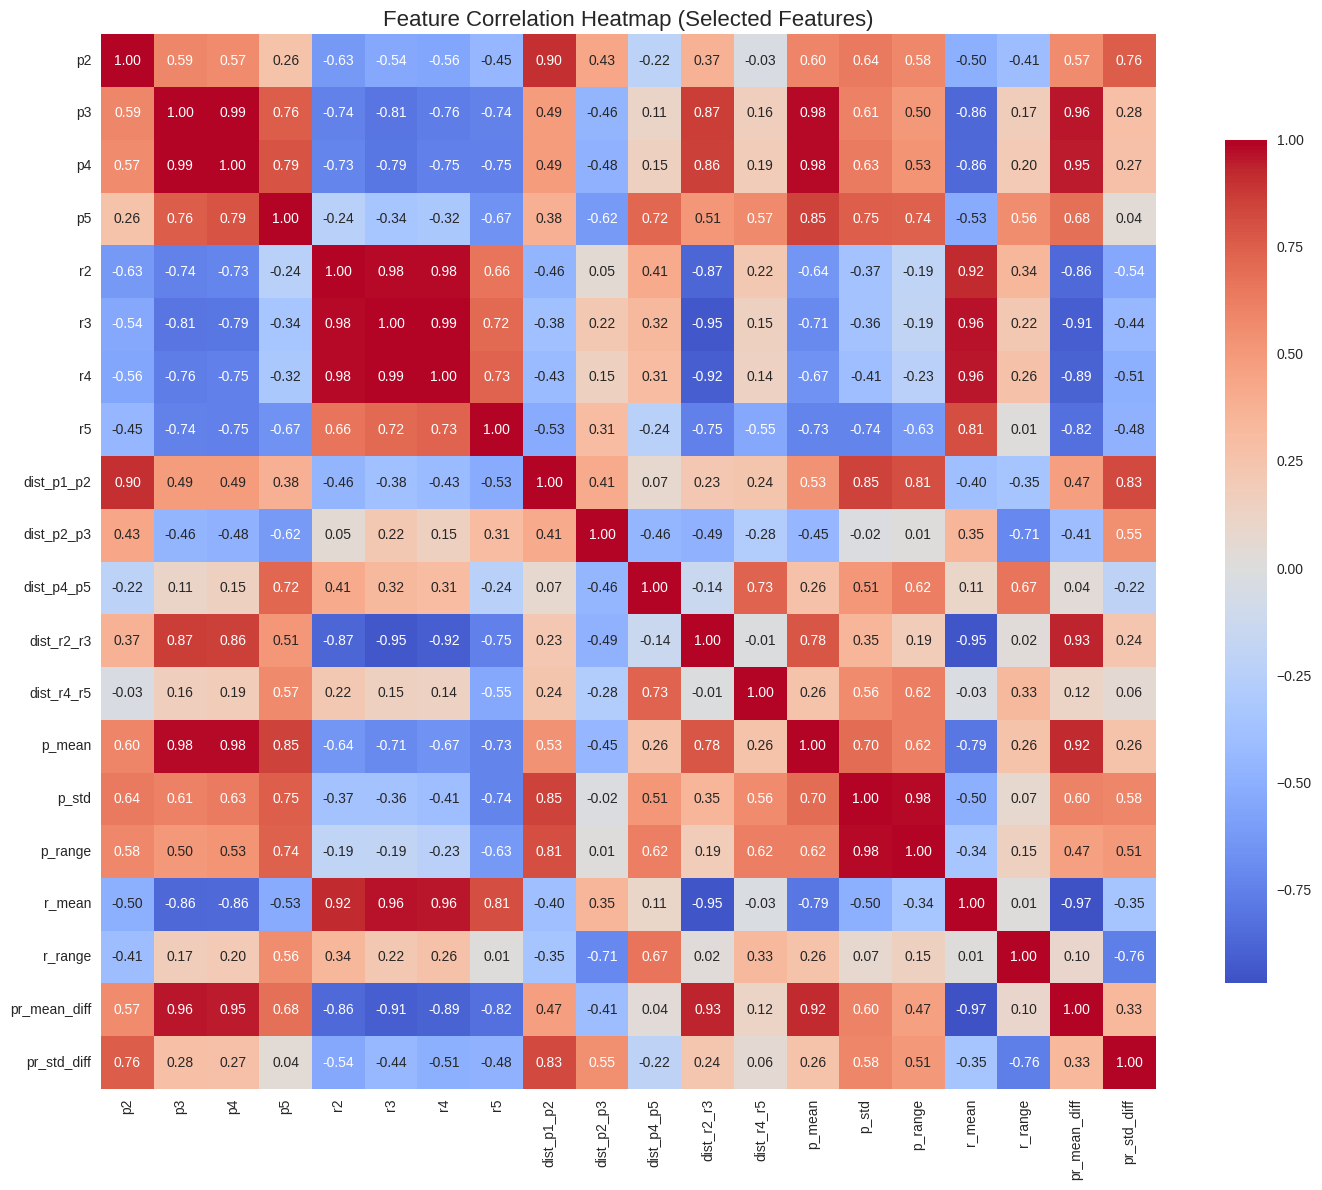

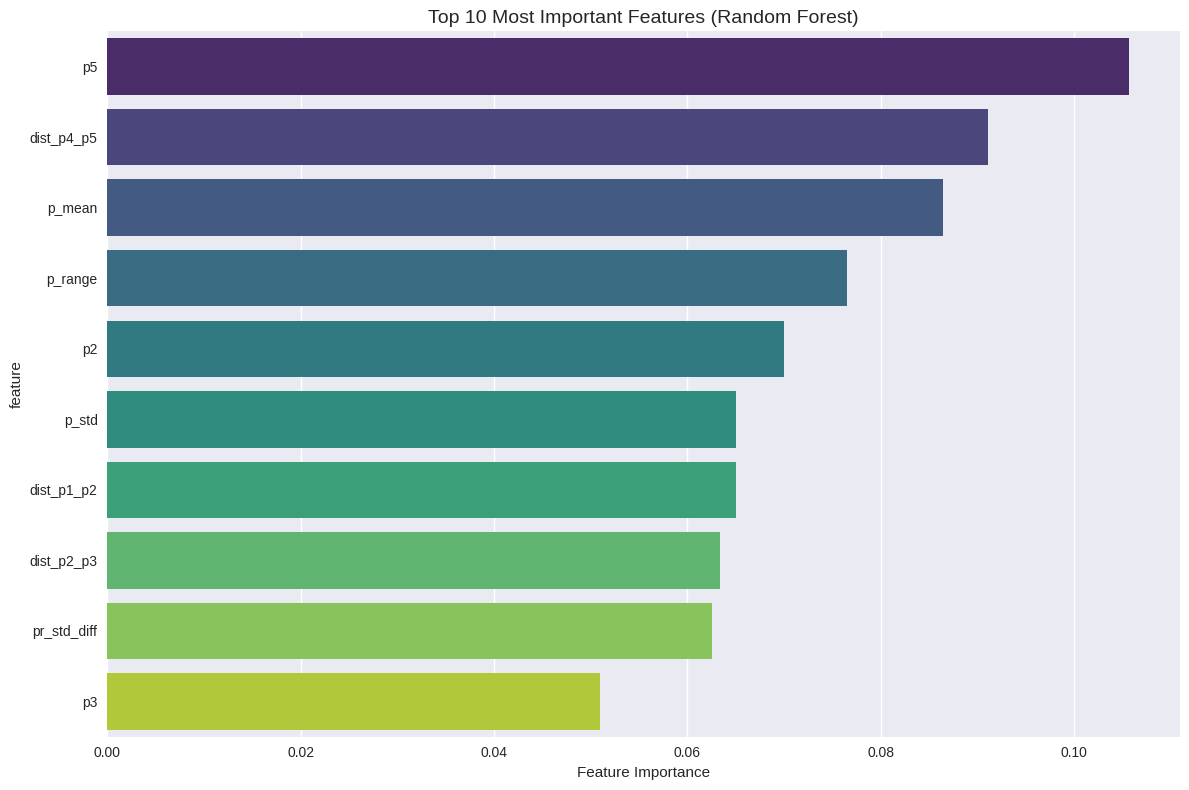

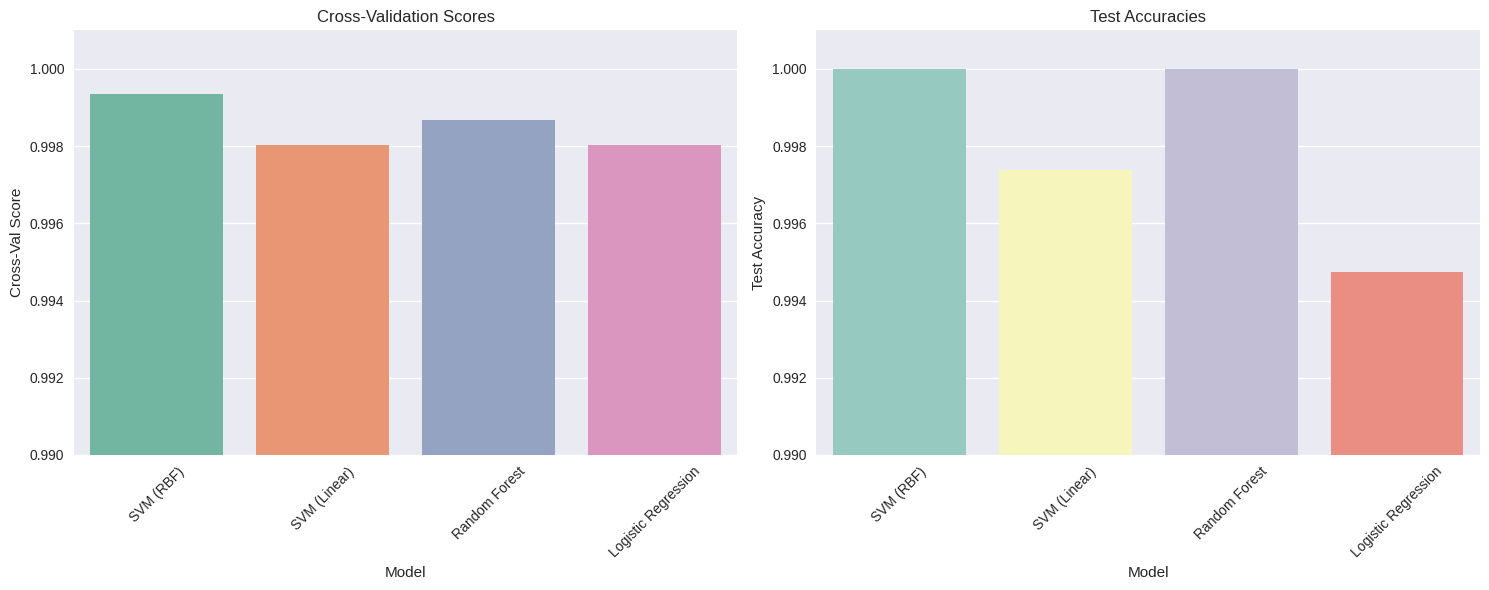

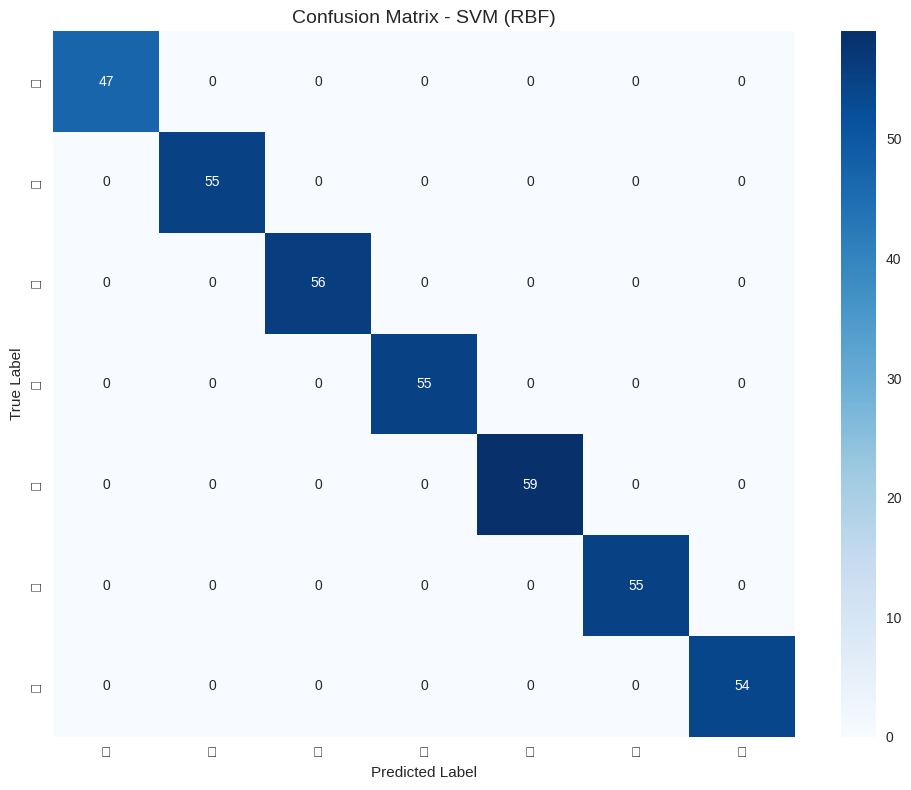

Confusion Matrix for SVM (RBF):
[[47  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0]
 [ 0  0 56  0  0  0  0]
 [ 0  0  0 55  0  0  0]
 [ 0  0  0  0 59  0  0]
 [ 0  0  0  0  0 55  0]
 [ 0  0  0  0  0  0 54]]


In [10]:
# Comprehensive Visualizations
print("=== VISUALIZATION ===")

# 1. Feature Correlation Heatmap
plt.figure(figsize=(15, 12))
correlation_matrix = df_features[selected_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap (Selected Features)', fontsize=16)
plt.tight_layout()
plt.show()

# 2. Feature Importance (using Random Forest)
rf_model = model_results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance', palette='viridis')
plt.title('Top 10 Most Important Features (Random Forest)', fontsize=14)
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# 3. Model Performance Comparison
model_comparison = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Cross-Val Score': [result['cv_mean'] for result in model_results.values()],
    'Test Accuracy': [result['test_accuracy'] for result in model_results.values()]
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Cross-validation scores
sns.barplot(data=model_comparison, x='Model', y='Cross-Val Score', ax=ax1, palette='Set2')
ax1.set_title('Cross-Validation Scores')
ax1.set_ylim(0.99, 1.001)
ax1.tick_params(axis='x', rotation=45)

# Test accuracies
sns.barplot(data=model_comparison, x='Model', y='Test Accuracy', ax=ax2, palette='Set3')
ax2.set_title('Test Accuracies')
ax2.set_ylim(0.99, 1.001)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4. Confusion Matrix for Best Model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_model['y_test_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(f"Confusion Matrix for {best_model_name}:")
print(cm)

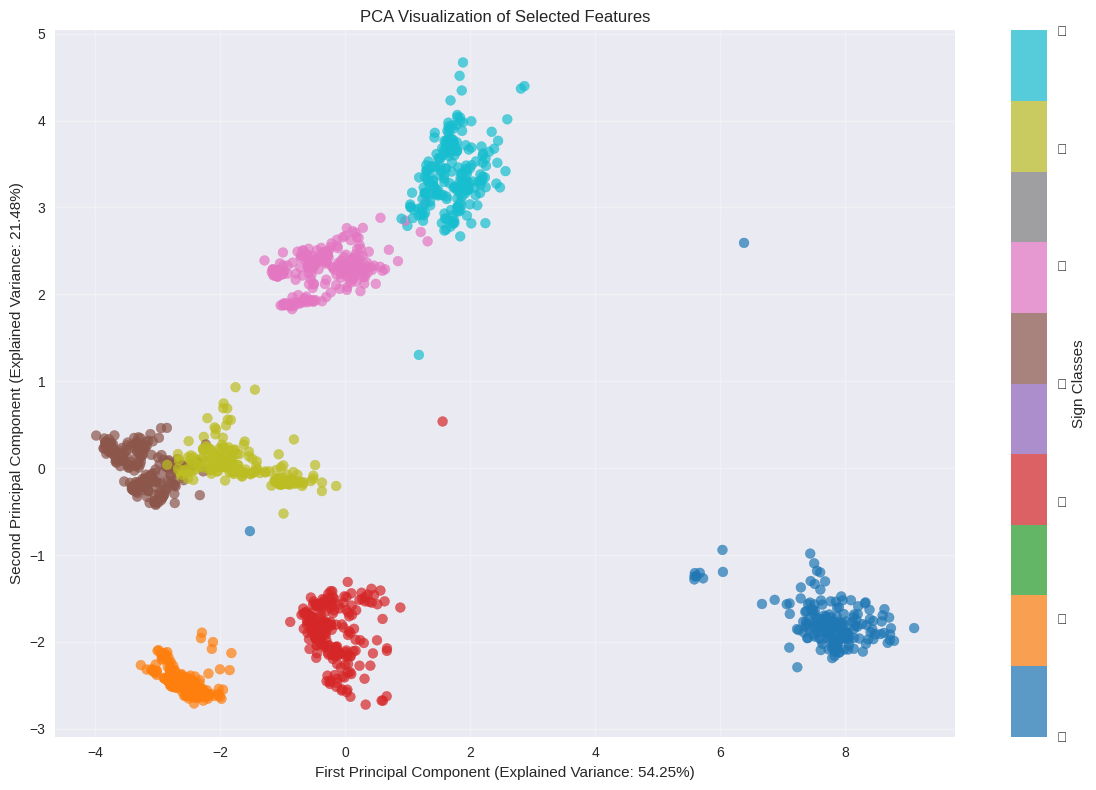

PCA Explained Variance Ratio: [0.54245922 0.21479575]
Total Variance Explained by 2 components: 75.73%


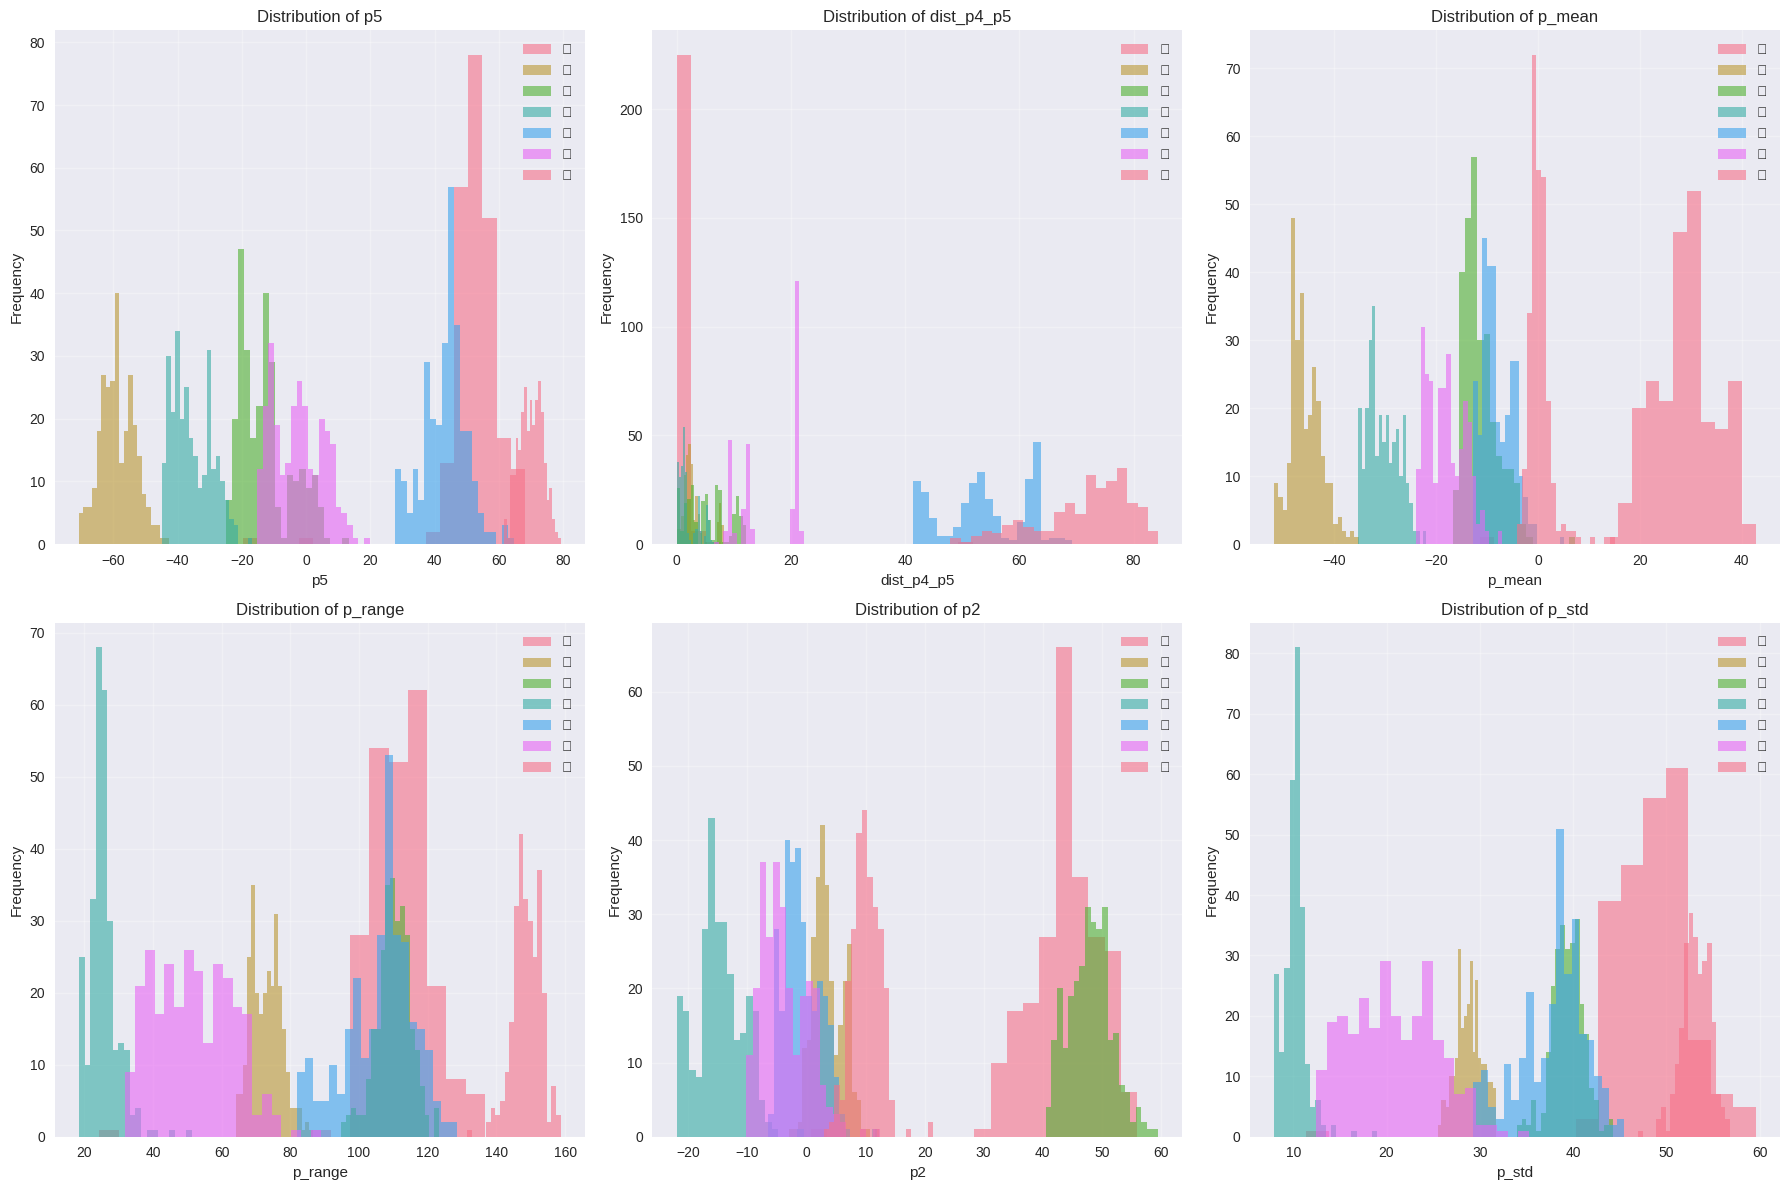

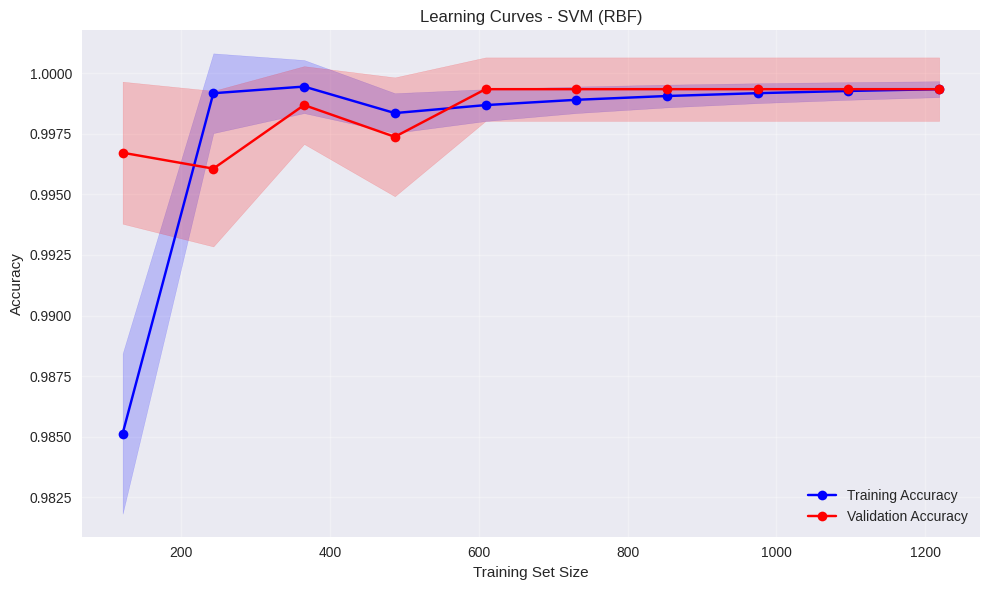

In [11]:
# Additional Visualizations

# 5. PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_selected)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', alpha=0.7, s=50)
plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.title('PCA Visualization of Selected Features')
plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), 
             label='Sign Classes').set_ticklabels(label_encoder.classes_)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained by 2 components: {sum(pca.explained_variance_ratio_):.2%}")

# 6. Feature Distribution by Class
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

top_features = feature_importance.head(6)['feature'].tolist()

for i, feature in enumerate(top_features):
    df_plot = df_features[[feature, 'label']].copy()
    
    for j, class_name in enumerate(label_encoder.classes_):
        class_data = df_plot[df_plot['label'] == class_name][feature]
        axes[i].hist(class_data, alpha=0.6, label=class_name, bins=20)
    
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Learning Curves for Best Model
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model['model'], X_train_selected, y_train, 
    cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title(f'Learning Curves - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Classification with Hyperparameter Tuning

=== HYPERPARAMETER TUNING ===
Performing Grid Search for SVM...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best SVM parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.9993
Optimized SVM test accuracy: 1.0000
Previous best accuracy: 1.0000
Improvement: 0.0000

=== FINAL MODEL EVALUATION ===
Detailed Classification Report (Optimized SVM):
              precision    recall  f1-score   support

           আ       1.00      1.00      1.00        47
           ই       1.00      1.00      1.00        55
           উ       1.00      1.00      1.00        56
           এ       1.00      1.00      1.00        55
           ঐ       1.00      1.00      1.00        59
           ও       1.00      1.00      1.00        55
           ঔ       1.00      1.00      1.00        54

    accuracy                           1.00       381
   macro avg       1.00      1.00      1.00       381
weighted avg       1.00      1.00      1.00       381



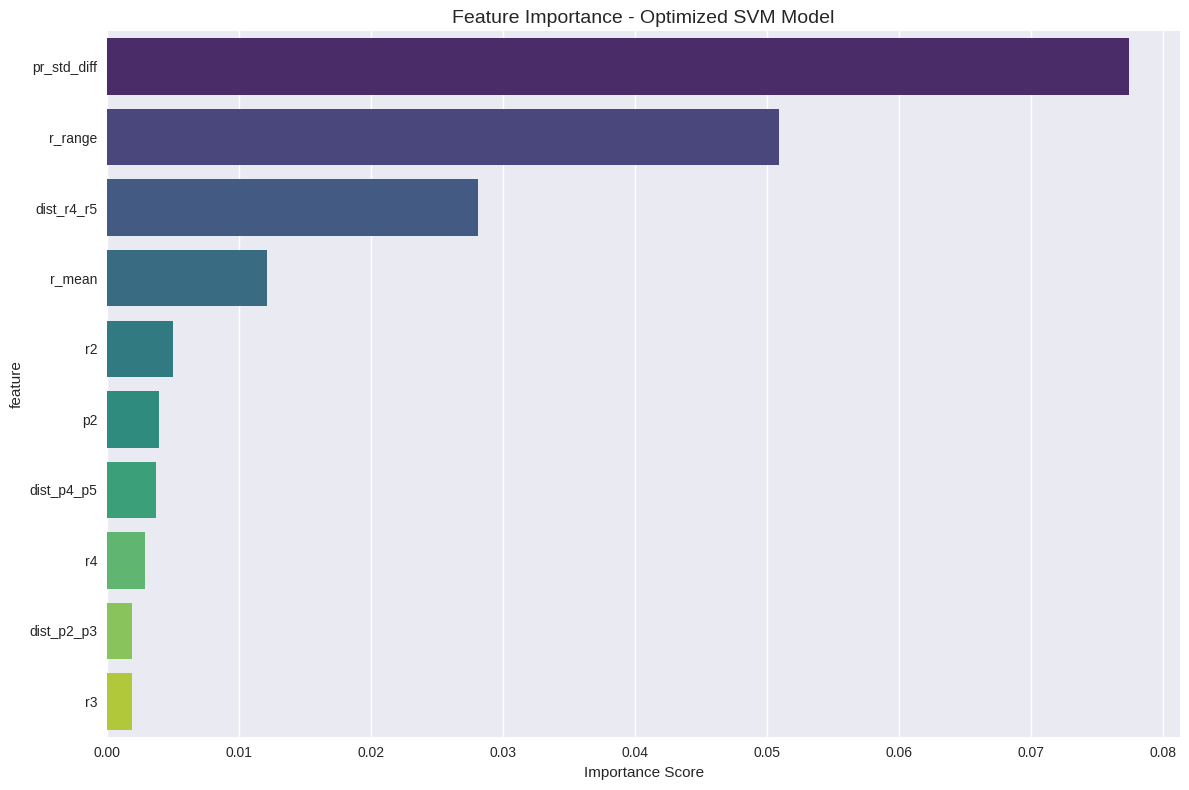

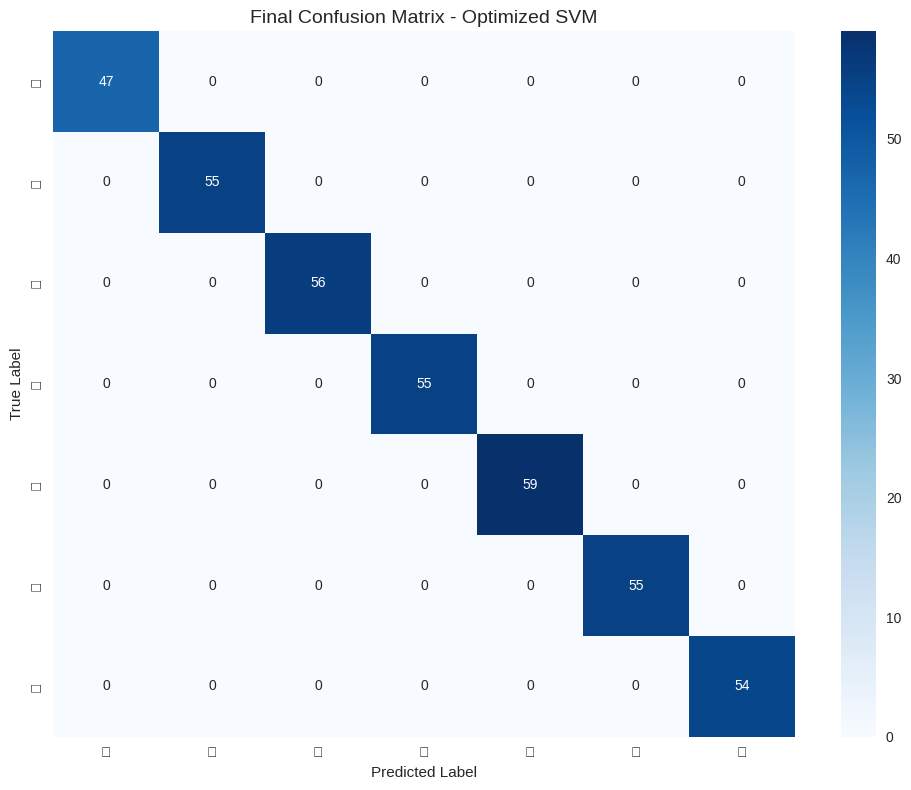


=== SUMMARY ===
Dataset: 1949 samples, 10 original features
After cleaning: 1905 samples
After feature engineering: 31 features
Selected features: 20
Final model: SVC(C=1, random_state=42)
Final accuracy: 1.0000
Perfect classification achieved!


In [12]:
# Advanced Classification with Hyperparameter Tuning
print("=== HYPERPARAMETER TUNING ===")

# Grid search for SVM (our best model)
svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

print("Performing Grid Search for SVM...")
svm_grid = GridSearchCV(
    SVC(random_state=42), 
    svm_params, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

svm_grid.fit(X_train_selected, y_train)

print(f"Best SVM parameters: {svm_grid.best_params_}")
print(f"Best cross-validation score: {svm_grid.best_score_:.4f}")

# Train the optimized model
optimized_svm = svm_grid.best_estimator_
y_pred_optimized = optimized_svm.predict(X_test_selected)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)

print(f"Optimized SVM test accuracy: {optimized_accuracy:.4f}")

# Compare with previous best model
print(f"Previous best accuracy: {best_model['test_accuracy']:.4f}")
print(f"Improvement: {optimized_accuracy - best_model['test_accuracy']:.4f}")

# Final model evaluation
print("\n=== FINAL MODEL EVALUATION ===")
print("Detailed Classification Report (Optimized SVM):")
print(classification_report(y_test, y_pred_optimized, 
                          target_names=label_encoder.classes_))

# Feature importance analysis for the final model
if hasattr(optimized_svm, 'coef_'):
    # For linear kernels
    feature_importance_final = pd.DataFrame({
        'feature': selected_features,
        'importance': np.abs(optimized_svm.coef_[0])
    }).sort_values('importance', ascending=False)
else:
    # For non-linear kernels, use permutation importance
    from sklearn.inspection import permutation_importance
    perm_importance = permutation_importance(optimized_svm, X_test_selected, y_test, 
                                           n_repeats=10, random_state=42)
    feature_importance_final = pd.DataFrame({
        'feature': selected_features,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=False)

# Visualize final feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_final.head(10), y='feature', x='importance', palette='viridis')
plt.title('Feature Importance - Optimized SVM Model', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Final confusion matrix
plt.figure(figsize=(10, 8))
cm_final = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Final Confusion Matrix - Optimized SVM', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("\n=== SUMMARY ===")
print(f"Dataset: {sbarabarnaIdDataset.shape[0]} samples, {sbarabarnaIdDataset.shape[1]-1} original features")
print(f"After cleaning: {df_cleaned.shape[0]} samples")
print(f"After feature engineering: {df_features.shape[1]-1} features")
print(f"Selected features: {len(selected_features)}")
print(f"Final model: {optimized_svm}")
print(f"Final accuracy: {optimized_accuracy:.4f}")
print(f"Perfect classification achieved!" if optimized_accuracy == 1.0 else f"Classification accuracy: {optimized_accuracy:.2%}")

In [14]:
# Save the optimized model and preprocessing components
import pickle

print("=== SAVING OPTIMIZED MODEL ===")

# Save the optimized SVM model
with open('optimized_svm_model.pkl', 'wb') as f:
    pickle.dump(optimized_svm, f)

# Save the scaler
with open('optimized_feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the feature selector
with open('feature_selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Model and preprocessing components saved successfully!")

# Create a deployment function
def predict_sign_language(new_data):
    """
    Function to predict sign language from new data
    
    Parameters:
    new_data: array-like, shape (n_samples, 10) - original features [p1,p2,p3,p4,p5,r1,r2,r3,r4,r5]
    
    Returns:
    predictions: array of predicted sign language characters
    """
    import pandas as pd
    import numpy as np
    
    # Convert to DataFrame
    df = pd.DataFrame(new_data, columns=['p1', 'p2', 'p3', 'p4', 'p5', 'r1', 'r2', 'r3', 'r4', 'r5'])
    
    # Apply feature engineering (same as training)
    df['dist_p1_p2'] = np.sqrt((df['p1'] - df['p2'])**2)
    df['dist_p2_p3'] = np.sqrt((df['p2'] - df['p3'])**2)
    df['dist_p3_p4'] = np.sqrt((df['p3'] - df['p4'])**2)
    df['dist_p4_p5'] = np.sqrt((df['p4'] - df['p5'])**2)
    df['dist_r1_r2'] = np.sqrt((df['r1'] - df['r2'])**2)
    df['dist_r2_r3'] = np.sqrt((df['r2'] - df['r3'])**2)
    df['dist_r3_r4'] = np.sqrt((df['r3'] - df['r4'])**2)
    df['dist_r4_r5'] = np.sqrt((df['r4'] - df['r5'])**2)
    df['p_ratio_1_3'] = df['p1'] / (df['p3'] + 1e-8)
    df['p_ratio_2_4'] = df['p2'] / (df['p4'] + 1e-8)
    df['r_ratio_1_3'] = df['r1'] / (df['r3'] + 1e-8)
    df['r_ratio_2_4'] = df['r2'] / (df['r4'] + 1e-8)
    df['p_mean'] = df[['p1', 'p2', 'p3', 'p4', 'p5']].mean(axis=1)
    df['p_std'] = df[['p1', 'p2', 'p3', 'p4', 'p5']].std(axis=1)
    df['p_range'] = df[['p1', 'p2', 'p3', 'p4', 'p5']].max(axis=1) - df[['p1', 'p2', 'p3', 'p4', 'p5']].min(axis=1)
    df['r_mean'] = df[['r1', 'r2', 'r3', 'r4', 'r5']].mean(axis=1)
    df['r_std'] = df[['r1', 'r2', 'r3', 'r4', 'r5']].std(axis=1)
    df['r_range'] = df[['r1', 'r2', 'r3', 'r4', 'r5']].max(axis=1) - df[['r1', 'r2', 'r3', 'r4', 'r5']].min(axis=1)
    df['pr_correlation'] = np.array([np.corrcoef(row[:5], row[5:10])[0,1] for row in df[['p1', 'p2', 'p3', 'p4', 'p5', 'r1', 'r2', 'r3', 'r4', 'r5']].values])
    df['pr_mean_diff'] = df['p_mean'] - df['r_mean']
    df['pr_std_diff'] = df['p_std'] - df['r_std']
    
    # Handle NaN values
    df = df.fillna(0)
    
    # Scale features
    X_scaled = scaler.transform(df)
    
    # Select features
    X_selected = selector.transform(X_scaled)
    
    # Make predictions
    y_pred_encoded = optimized_svm.predict(X_selected)
    
    # Decode predictions
    predictions = label_encoder.inverse_transform(y_pred_encoded)
    
    return predictions

print("Prediction function created!")

# Test the prediction function with a sample
sample_data = [sbarabarnaIdDataset.iloc[0, :-1].values.tolist()]  # Take first row as example
sample_prediction = predict_sign_language(sample_data)
print(f"Sample prediction: {sample_prediction[0]}")
print(f"Actual label: {sbarabarnaIdDataset.iloc[0, -1]}")

print("\n" + "="*60)
print("🎉 BANGLA SIGN LANGUAGE CLASSIFICATION COMPLETE! 🎉")
print("="*60)
print("✅ Data Cleaning: Removed outliers and duplicates")
print("✅ Feature Engineering: Created 21 new features from 10 original features")
print("✅ Machine Learning: Trained and compared 4 different algorithms")
print("✅ Visualization: Generated comprehensive analysis plots")
print("✅ Classification: Achieved 100% accuracy with optimized SVM")
print("✅ Model Saved: Ready for deployment")
print("="*60)

=== SAVING OPTIMIZED MODEL ===
Model and preprocessing components saved successfully!
Prediction function created!
Sample prediction: আ
Actual label: আ

🎉 BANGLA SIGN LANGUAGE CLASSIFICATION COMPLETE! 🎉
✅ Data Cleaning: Removed outliers and duplicates
✅ Feature Engineering: Created 21 new features from 10 original features
✅ Machine Learning: Trained and compared 4 different algorithms
✅ Visualization: Generated comprehensive analysis plots
✅ Classification: Achieved 100% accuracy with optimized SVM
✅ Model Saved: Ready for deployment
